# Imports

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.stats import shapiro, mannwhitneyu, wilcoxon, kruskal
from itertools import combinations

# BenchMarks - "Apenas" Temperatura Máxima

##Generalizando

In [34]:
def ler_em_dataframe(lista_paths):

  lista_df_timeit = []

  for path in lista_paths:

    lista_df_timeit.append(pd.read_json(path, lines=True).transpose())

  return lista_df_timeit


In [35]:
def renomear_dataframes(lista_df_timeit, lista_labels):

  for df_timeit, label in zip(lista_df_timeit, lista_labels):

    df_timeit.columns = [label]

  return lista_df_timeit


In [47]:
def concatenar_dataframes(lista_df_timeit):

  df_tempos_timeit_geral = pd.concat(lista_df_timeit, axis = 1)

  print(df_tempos_timeit_geral)

  return df_tempos_timeit_geral


In [37]:
def checar_valores_nan(df_tempos_timeit_geral):

  if df_tempos_timeit_geral.isna().sum().any() > 0:

    raise ValueError("O DataFrame contém valores NaN.")

  return 'Nenhum valor NaN presente no dataframe'


In [38]:
def obters_valores_normalidade_shapiro_wilk(df_tempos_timeit_geral):

  valores_teste_normalidade_shapiro = []

  for grupo in df_tempos_timeit_geral.columns:

    valor_shapiro_normalidade = shapiro(df_tempos_timeit_geral[grupo])[1]

    valores_teste_normalidade_shapiro.append((valor_shapiro_normalidade, grupo))

  return valores_teste_normalidade_shapiro


In [39]:
def checar_normalidade_shapiro_wilk(valores_teste_normalidade_shapiro_wilk):

  conclusao_teste_normalidade_shapiro = []

  print('O teste de normalidade aplicado é o teste de Shapiro-Wilk.\n')

  for valor_teste_normalidade in valores_teste_normalidade_shapiro_wilk:

    if valor_teste_normalidade[0] < 0.05:

      conclusao = f'O valor do teste de Shapiro-Wilk para o grupo {valor_teste_normalidade[1]} foi de {valor_teste_normalidade[0]} (menor do que o valor p definido de 0.05). Assim a hipótese nula foi rejeitada com nível de confianca de 95%. Assim aceitando a hipótese alternativa de que os dados de amostra não são provenientes de uma distribuição normal.'

    else:

      conclusao = f'O valor do teste de Shapiro-Wilk para o grupo {valor_teste_normalidade[1]} foi de {valor_teste_normalidade[0]} (não menor do que o valor p definido de 0.05). Assim a hipótese nula foi aceita com nível de confiança de 95%. Concluindo que os dados de amostra são provenientes de uma distribuição normal.'

    conclusao_teste_normalidade_shapiro.append(conclusao)

  return conclusao_teste_normalidade_shapiro


In [49]:
def plotar_distribuicao_2_a_2(df_tempos_timeit_geral, label_coluna_1, label_coluna_2): # 2 a 2

  plt.figure(figsize=(15, 10))

  sns.histplot(df_tempos_timeit_geral[label_coluna_1], color='blue', kde=True, label=label_coluna_1)

  sns.histplot(df_tempos_timeit_geral[label_coluna_2], color='red', kde=True, label=label_coluna_2)

  plt.xlabel('Valores')
  plt.ylabel('Frequência')
  plt.title('Distribuição dos tempos de execução')
  plt.grid(True)

  plt.legend()


  plt.show()


In [41]:
def realizar_teste_Mann_Whitney_uni_caudal_inferior(df_tempos_timeit_geral, label_coluna_1, label_coluna_2):

  valor_mann_whitney_resultado_inferior = mannwhitneyu(df_tempos_timeit_geral[label_coluna_1], df_tempos_timeit_geral[label_coluna_2], alternative='less')[1]

  plotar_distribuicao_2_a_2(df_tempos_timeit_geral, label_coluna_1, label_coluna_2)

  if valor_mann_whitney_resultado_inferior< 0.05:

    return f'O valor do teste de Mann Whitney foi de {valor_mann_whitney_resultado_inferior} (menor do que 0.05). Sendo assim, rejeitamos, com nível de confiança de 95%, que o valor da verdadeira média de execução é igual entre os dois grupos ou de que a o valor da verdadeira média de execução do grupo amostral {label_coluna_1} é maior do que aquele do grupo {label_coluna_2}. Aceitando a hipótese alternativa de que o verdadeiro valor de média de tempo de execução do grupo {label_coluna_1} é menor do que o do grupo {label_coluna_2}'

  return 'A hipótese nula não foi rejeitada.'


In [42]:
def realizar_teste_Wilcoxon_uni_caudal_inferior(df_tempos_timeit_geral, label_coluna_1, label_coluna_2):

  valor_wilcoxon_resultado_inferior = wilcoxon(df_tempos_timeit_geral[label_coluna_1], df_tempos_timeit_geral[label_coluna_2], alternative='less')[1]

  plotar_distribuicao_2_a_2(df_tempos_timeit_geral, label_coluna_1, label_coluna_2)

  if valor_wilcoxon_resultado_inferior < 0.05:

    return f'O valor do teste de Wilcoxon foi de {valor_wilcoxon_resultado_inferior} (menor do que 0.05). Sendo assim, rejeitamos, com nível de confiança de 95%, que o valor da verdadeira média de execução é igual entre os dois grupos ou de que a o valor da verdadeira média de execução do grupo amostral {label_coluna_1} é maior do que aquele do grupo {label_coluna_2}. Aceitando a hipótese alternativa de que o verdadeiro valor de média de tempo de execução do grupo {label_coluna_1} é menor do que o do grupo {label_coluna_2}'

  return 'A hipótese nula não foi rejeitada.' # detalhar

In [43]:
def teste_inferior_todos_pares(df_tempos_timeit_geral, funcao_teste_nao_parametrico): # quebrar em duas funcoes

  lista_resultados_todos_testes = []

  colunas = df_tempos_timeit_geral.columns

  for coluna1, coluna2 in combinations(colunas, 2):

    resultado_1 = funcao_teste_nao_parametrico(df_tempos_timeit_geral, coluna1, coluna2)

    lista_resultados_todos_testes.append(resultado_1)

    resultado_2 = funcao_teste_nao_parametrico(df_tempos_timeit_geral, coluna2, coluna1)

    lista_resultados_todos_testes.append(resultado_2)

  return lista_resultados_todos_testes


In [44]:
def realizar_teste_Kruskal(df_tempos_timeit_geral): # confirma igualdade ou diferenca entre as médias dos n grupos. Não ordena.

  colunas = df_tempos_timeit_geral.columns

  quantidade_colunas = len(colunas)

  valor_teste_wilcoxon = kruskal(*[df_tempos_timeit_geral[coluna] for coluna in colunas])

  if valor_teste_wilcoxon[1] < 0.05:

    return f'O valor do teste de Kruskal-Wallis foi de {valor_teste_wilcoxon[1]} (menor do que 0.05). Sendo assim, rejeitamos, com nível de confiança de 95%, que o valor das verdadeiras médias de cada um dos {quantidade_colunas} grupos é igual. Aceitando a hipótese alternativa de que o verdadeiro valor de média de tempo de execução não é igual entre os {quantidade_colunas} grupos.'

  return 'A hipótese nula não foi rejeitada.'


In [45]:
def execucao_geral(lista_paths_labels):

  lista_paths = [tupla[0] for tupla in lista_paths_labels]

  lista_labels = [tupla[1] for tupla in lista_paths_labels]

  lista_dfs_timeit = ler_em_dataframe(lista_paths)

  lista_dfs_timeit = renomear_dataframes(lista_dfs_timeit, lista_labels)

  df_geral_timeit = concatenar_dataframes(lista_dfs_timeit)

  armazenar_arquivo_checagem_valores_nan = checar_valores_nan(df_geral_timeit)

  print('Estamos considerando alpha como 0.05. Os testes levam em conta o nível de confiança de 95%.\n\n\n')

  valores_teste_shapiro = obters_valores_normalidade_shapiro_wilk(df_geral_timeit)

  armazenar_arquivo_normalidade = checar_normalidade_shapiro_wilk(valores_teste_shapiro)

  print(armazenar_arquivo_normalidade)

  armazenar_arquivo_teste_Mann_Whitney_uni_caudal_inferior = teste_inferior_todos_pares(df_geral_timeit, realizar_teste_Mann_Whitney_uni_caudal_inferior)

  print(f'\n{armazenar_arquivo_teste_Mann_Whitney_uni_caudal_inferior}\n')

  armazenar_arquivo_teste_Wilcoxon_uni_caudal_inferior = teste_inferior_todos_pares(df_geral_timeit, realizar_teste_Wilcoxon_uni_caudal_inferior)

  print(f'\n{armazenar_arquivo_teste_Wilcoxon_uni_caudal_inferior}\n')

  armazenar_arquivo_teste_Kruskal = realizar_teste_Kruskal(df_geral_timeit)

  print(f'\n{armazenar_arquivo_teste_Kruskal}\n')

  return True


### Execução geral

     pyspark    pandas    polars
0   0.244178  1.088815  0.047144
1   0.170160  1.077986  0.000817
2   0.166293  1.076262  0.000255
3   0.301047  1.076942  0.000247
4   0.515386  1.791134  0.000247
5   0.164988  1.671787  0.000422
6   0.340957  1.065427  0.000226
7   0.300710  1.070627  0.000209
8   0.374460  1.061173  0.000240
9   0.453239  1.067168  0.000206
10  0.551801  1.070568  0.000142
11  0.261130  1.065434  0.000110
12  0.572991  1.065242  0.000104
13  0.349227  1.070343  0.000102
14  0.165436  1.068810  0.000101
15  0.280870  1.681728  0.000148
16  0.154677  1.771332  0.000117
17  0.253520  1.065930  0.000104
18  0.184200  1.074643  0.000101
19  0.190754  1.069888  0.000101
20  0.131166  1.065448  0.000100
21  0.233372  1.066076  0.000102
22  0.232008  1.063023  0.000100
23  0.121525  1.067674  0.000100
24  0.158260  1.060929  0.000141
25  0.151103  1.065517  0.000150
26  0.204508  1.582532  0.000124
27  0.196692  1.791731  0.000105
28  0.124813  1.149966  0.000102
29  0.1223

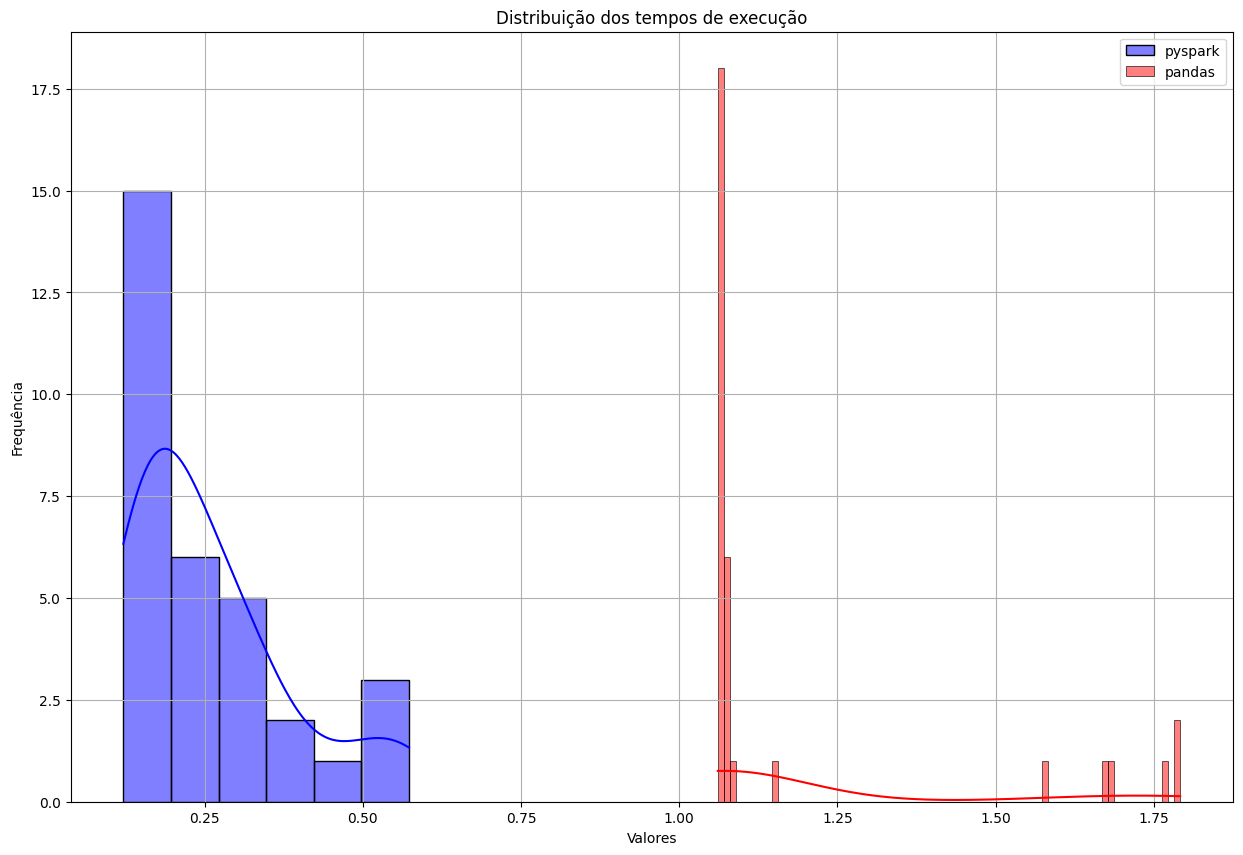

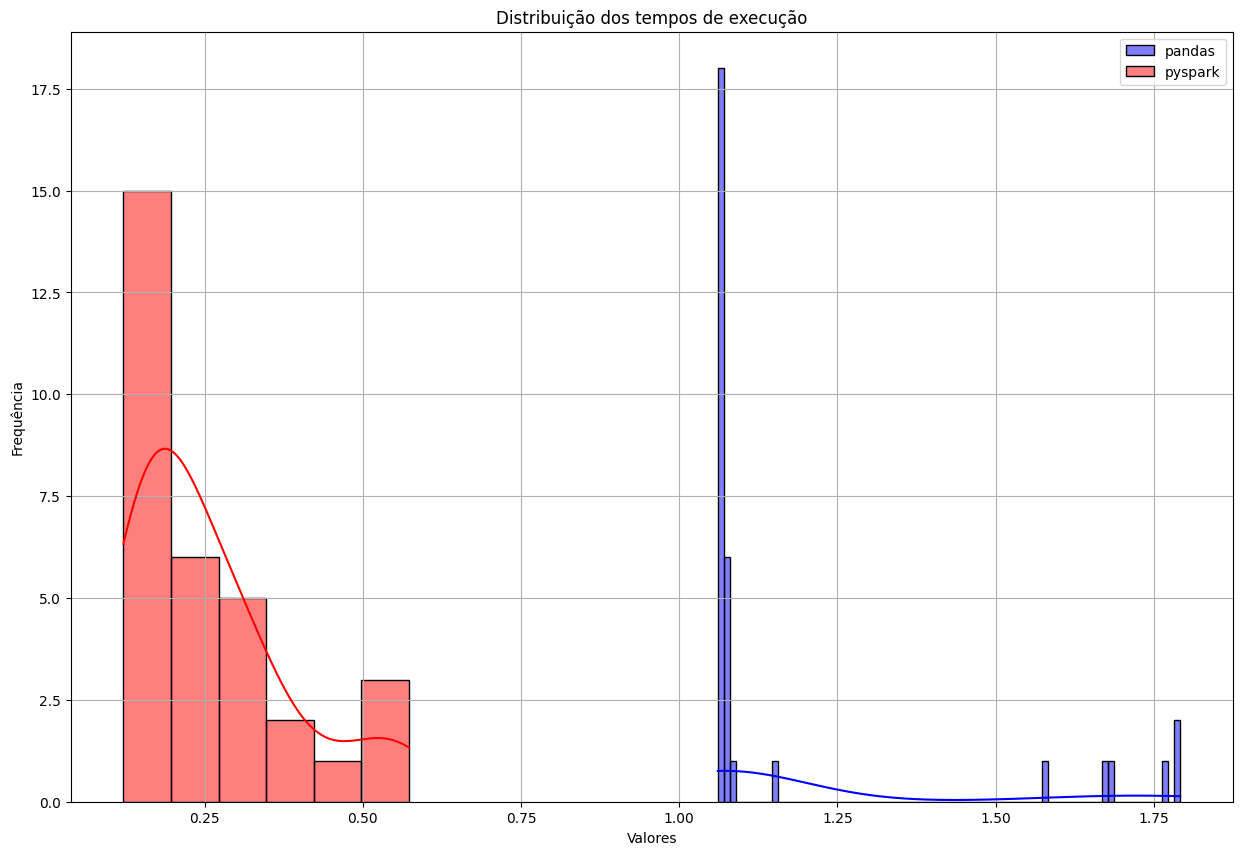

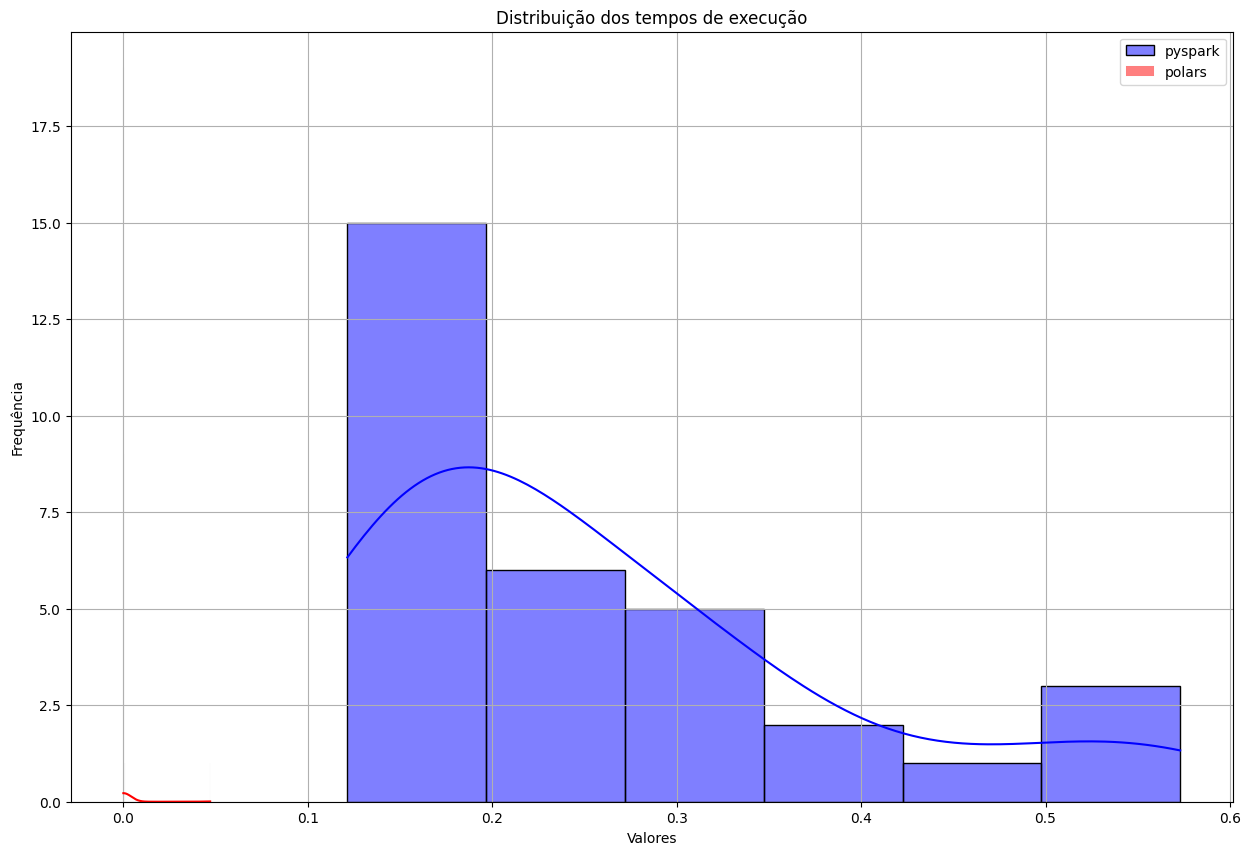

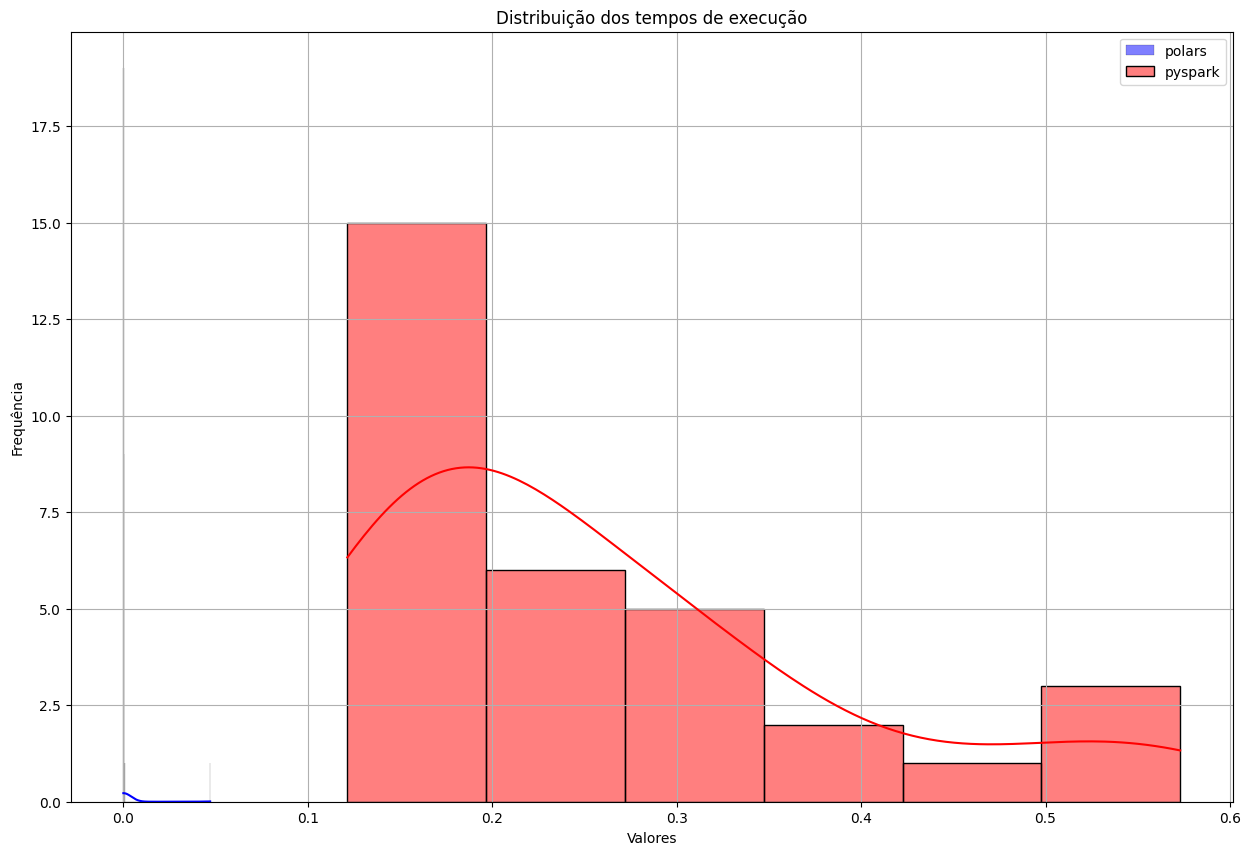

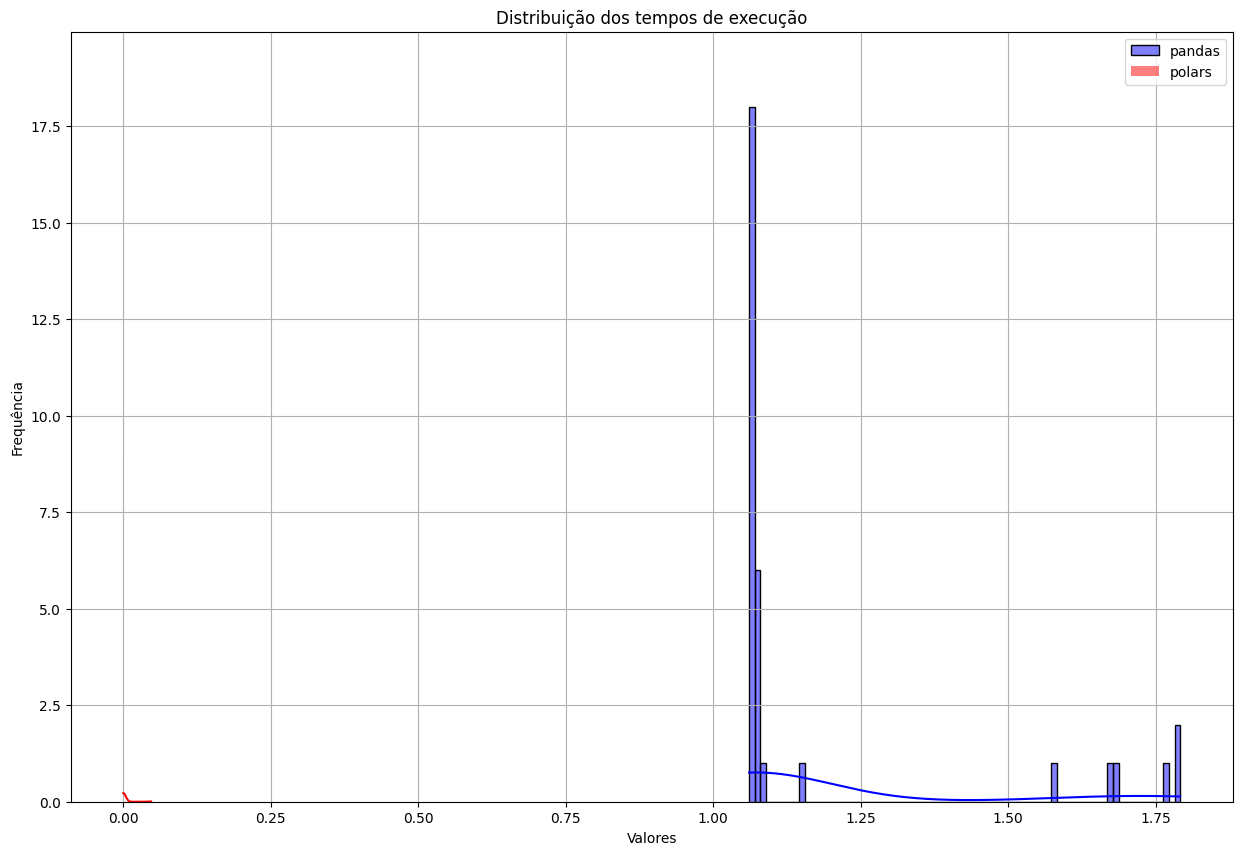

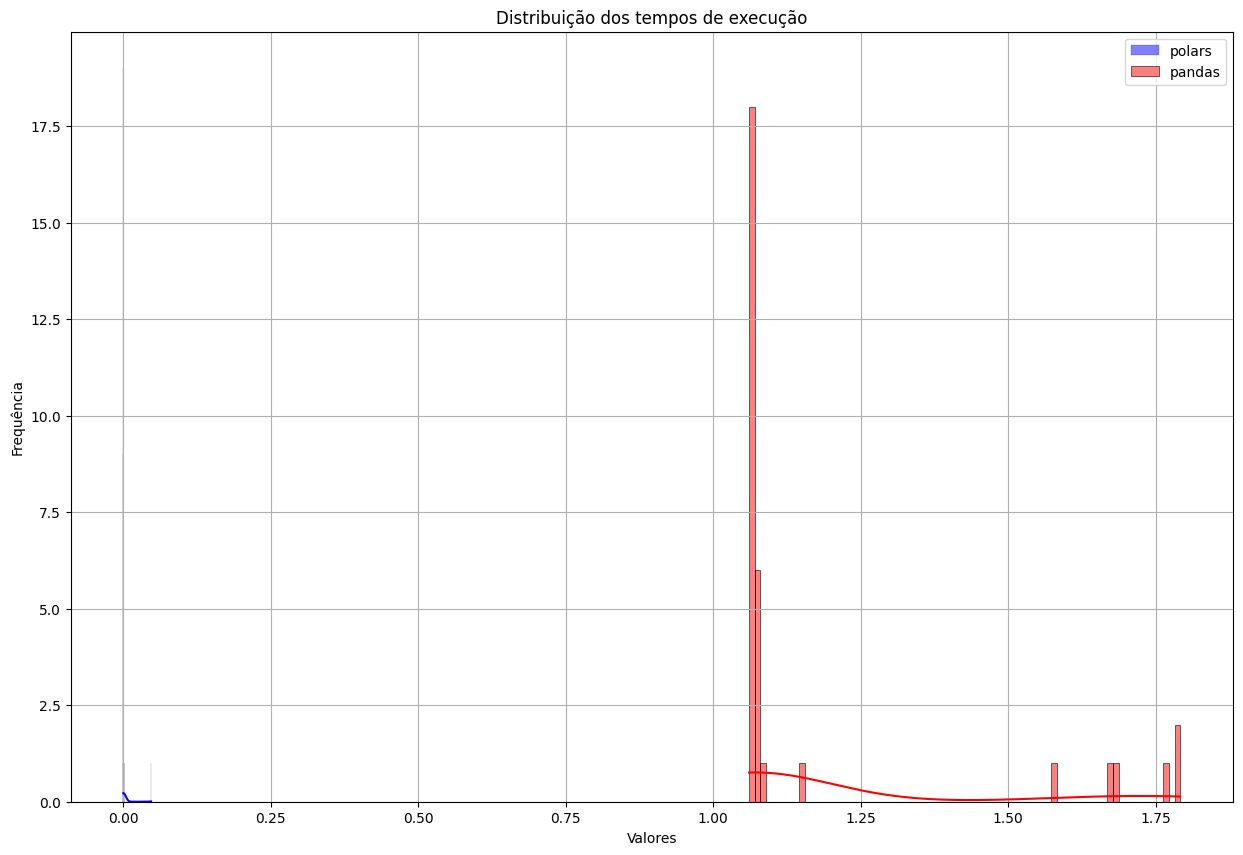


['O valor do teste de Mann Whitney foi de 3.255657150506507e-12 (menor do que 0.05). Sendo assim, rejeitamos, com nível de confiança de 95%, que o valor da verdadeira média de execução é igual entre os dois grupos ou de que a o valor da verdadeira média de execução do grupo amostral pyspark é maior do que aquele do grupo pandas. Aceitando a hipótese alternativa de que o verdadeiro valor de média de tempo de execução do grupo pyspark é menor do que o do grupo pandas', 'A hipótese nula não foi rejeitada.', 'A hipótese nula não foi rejeitada.', 'O valor do teste de Mann Whitney foi de 3.255657150506507e-12 (menor do que 0.05). Sendo assim, rejeitamos, com nível de confiança de 95%, que o valor da verdadeira média de execução é igual entre os dois grupos ou de que a o valor da verdadeira média de execução do grupo amostral polars é maior do que aquele do grupo pyspark. Aceitando a hipótese alternativa de que o verdadeiro valor de média de tempo de execução do grupo polars é menor do que o

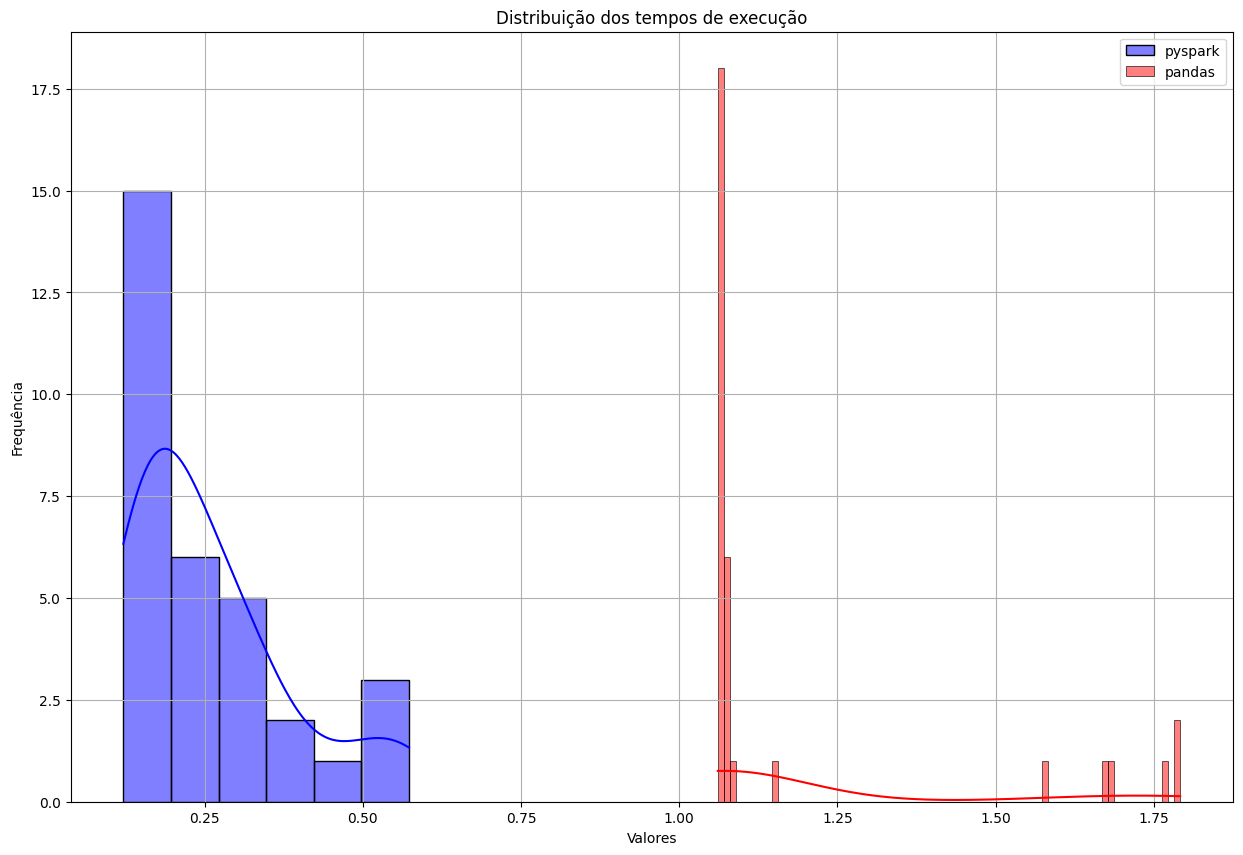

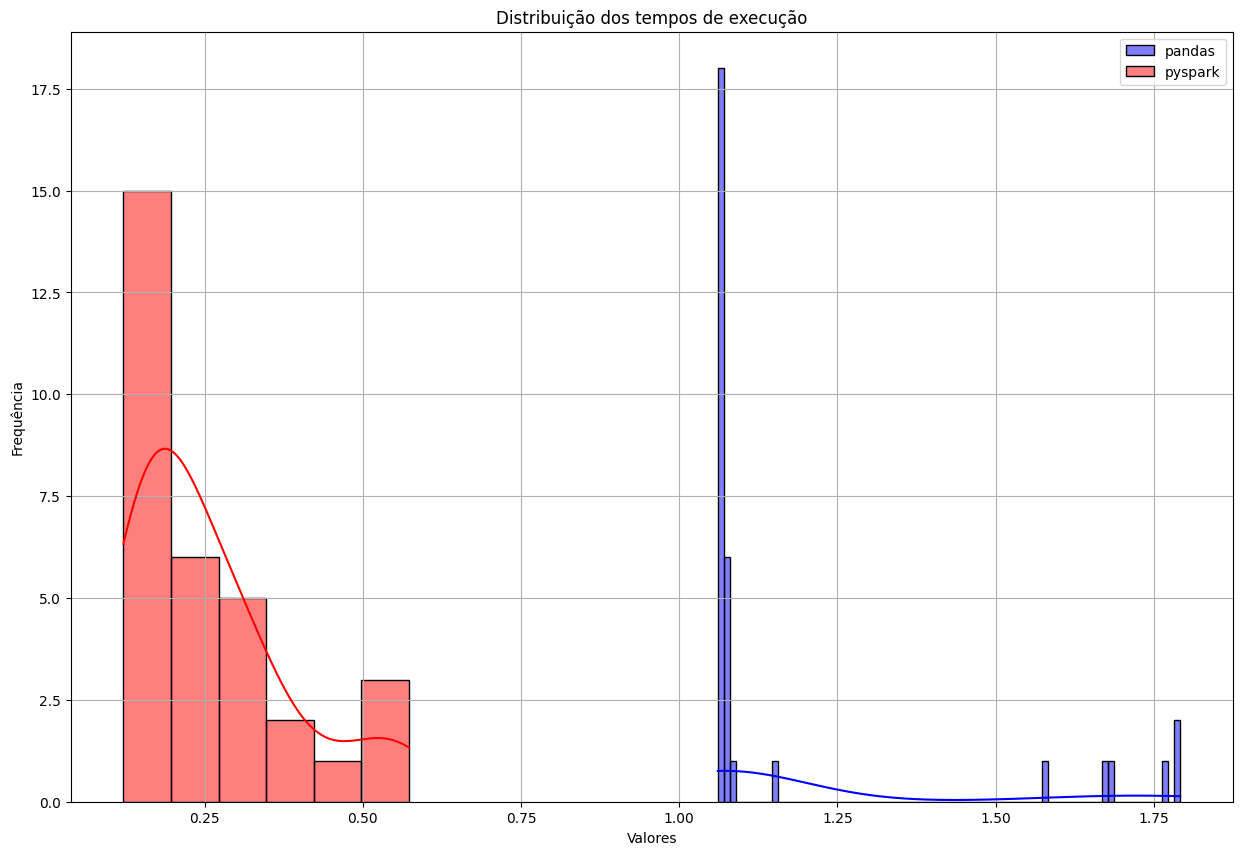

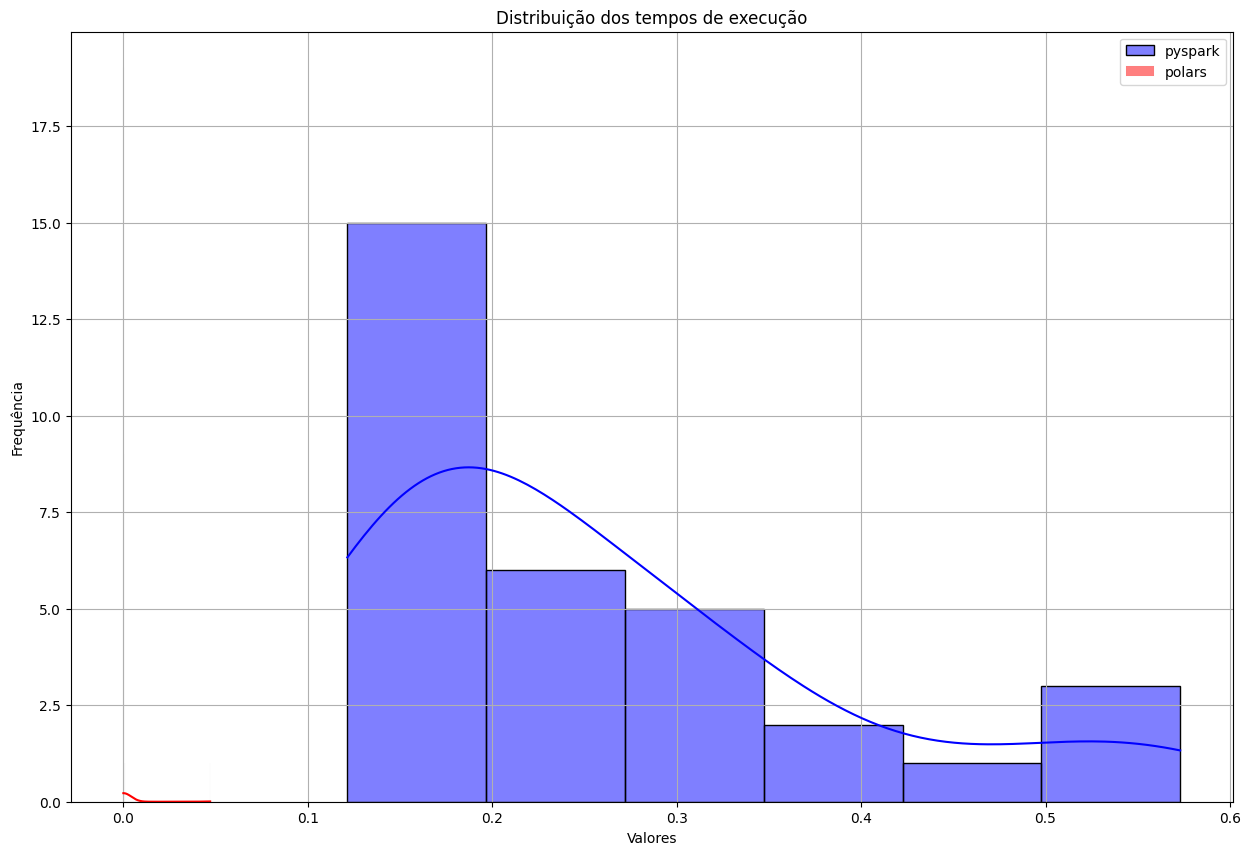

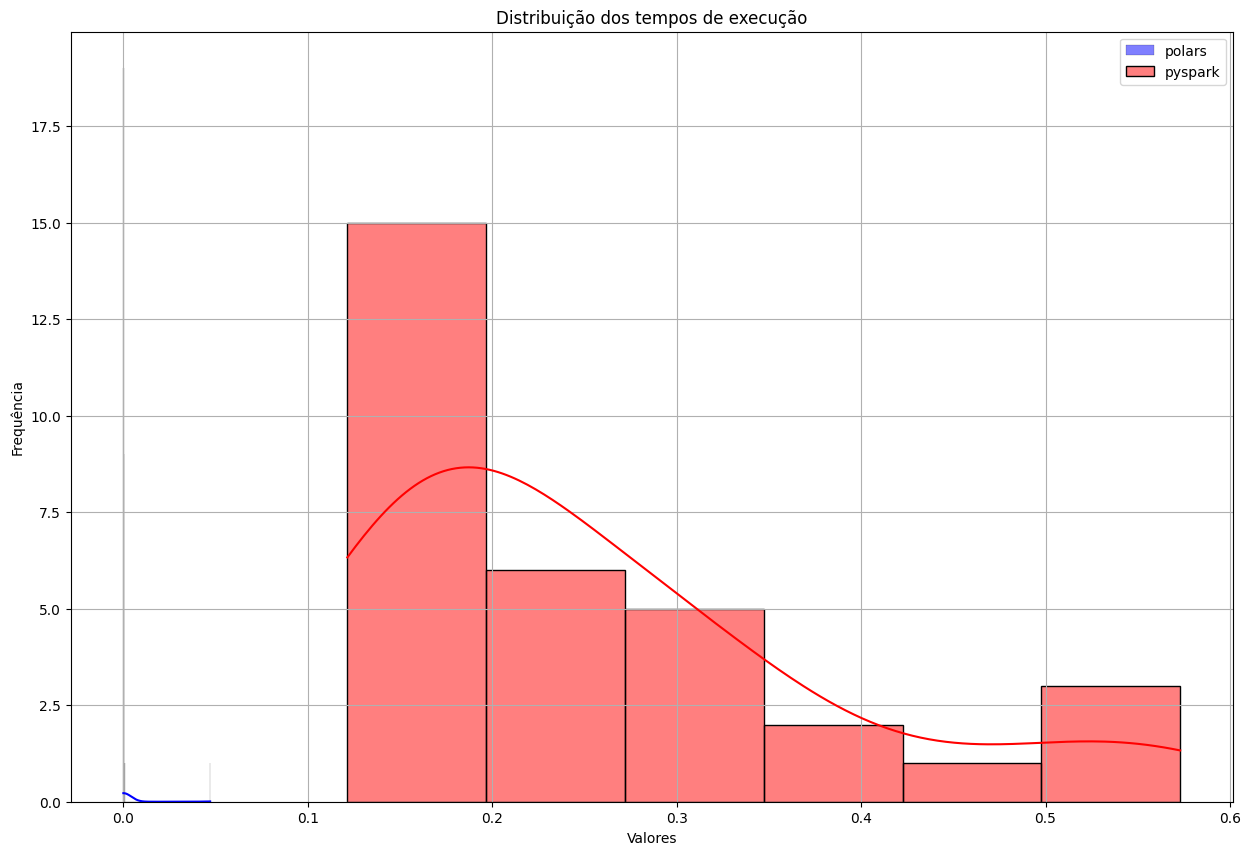

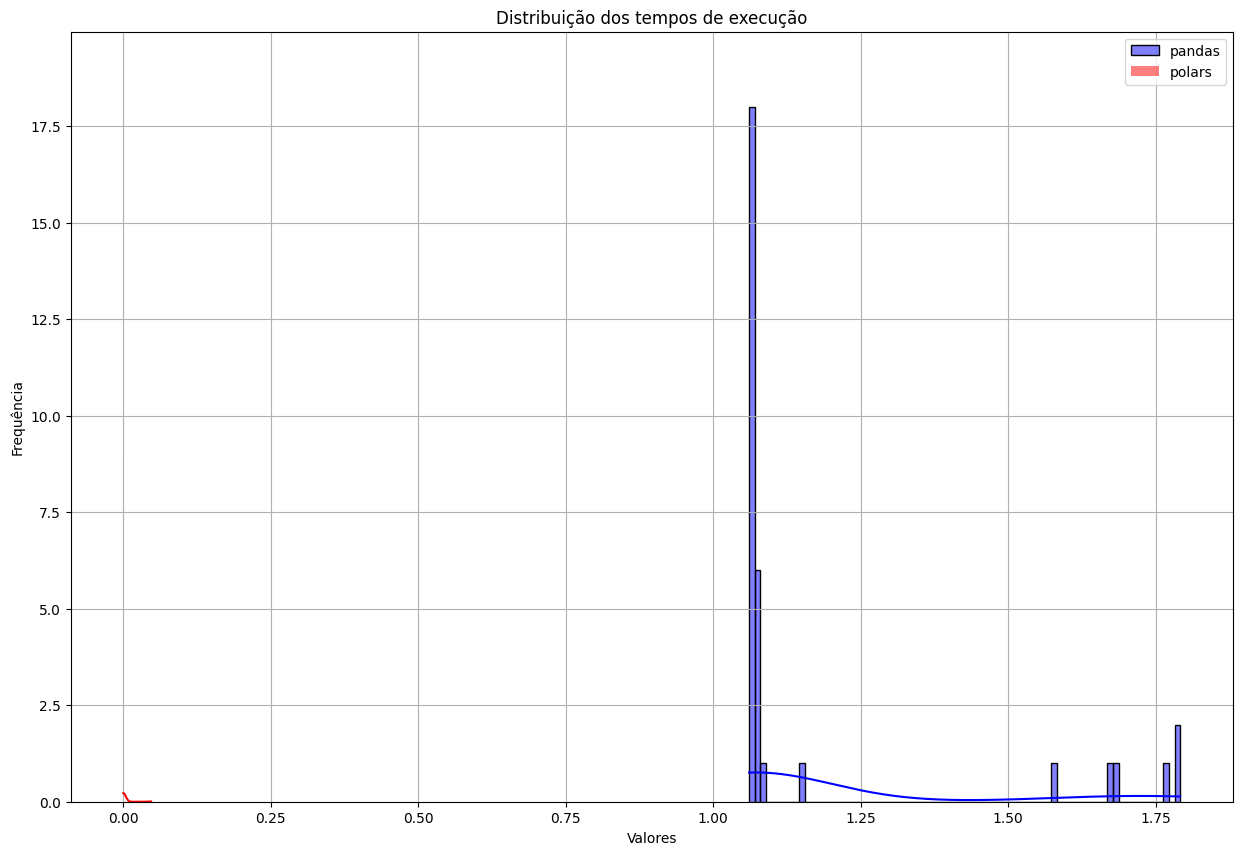

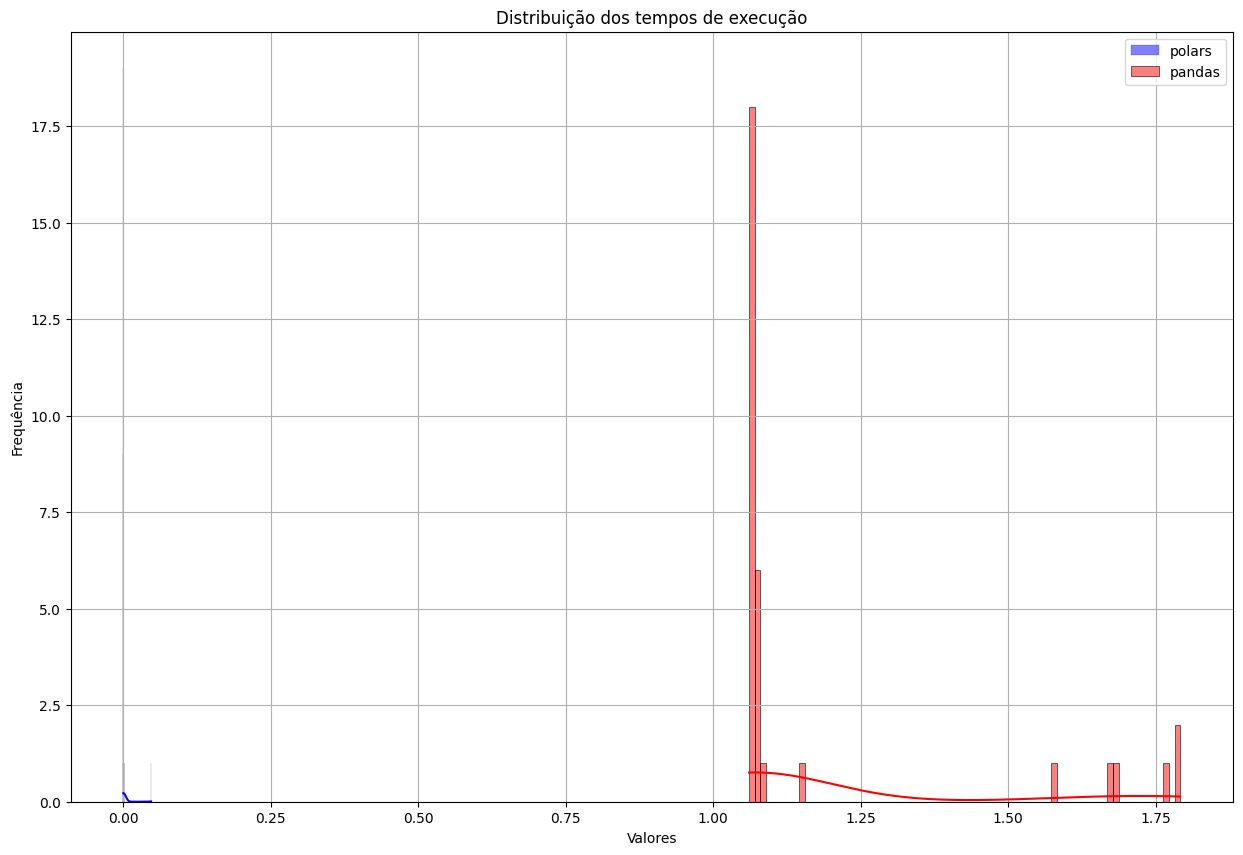


['O valor do teste de Wilcoxon foi de 2.3283064365386963e-10 (menor do que 0.05). Sendo assim, rejeitamos, com nível de confiança de 95%, que o valor da verdadeira média de execução é igual entre os dois grupos ou de que a o valor da verdadeira média de execução do grupo amostral pyspark é maior do que aquele do grupo pandas. Aceitando a hipótese alternativa de que o verdadeiro valor de média de tempo de execução do grupo pyspark é menor do que o do grupo pandas', 'A hipótese nula não foi rejeitada.', 'A hipótese nula não foi rejeitada.', 'O valor do teste de Wilcoxon foi de 2.3283064365386963e-10 (menor do que 0.05). Sendo assim, rejeitamos, com nível de confiança de 95%, que o valor da verdadeira média de execução é igual entre os dois grupos ou de que a o valor da verdadeira média de execução do grupo amostral polars é maior do que aquele do grupo pyspark. Aceitando a hipótese alternativa de que o verdadeiro valor de média de tempo de execução do grupo polars é menor do que o do gr

True

In [50]:
execucao_geral([('/content/tempos_timeit_10m_pyspark.json', 'pyspark'), ('/content/tempos_timeit_10m_pandas.json', 'pandas'), ('/content/tempos_timeit_10m_polars.json', 'polars')])